# Machine Learning project: "Chihuahua or muffin?"

<div>
<img src="Images_github/Meme.jpeg" width="600" align="center"/> 
</div>

This project explores the application of machine learning in image classification. The goal was to develop and examine a classifier that could accurately distinguish between classes. For this purpose three neural network architectures have been considered. For each of them, the expected minimal risk has been estimated through a variation of the nested cross validation and, in the end, the resulting three best models have been tested. 

### Load packages

In [1]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np
import PIL
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split,KFold
from tabulate import tabulate
import os

### Set dataset directories

In [2]:
train_dir = "Data/train"
test_dir = "Data/test"


A sample of images extracted from the train folder
<div>
<img src="Images_github/Images-2.png" width="500"/>
</div>

### Convert all images to RGB

In [3]:
# Check if there are images that are not in RGB

def check_img(dir_path) :

    files = os.listdir(dir_path)
    NotRGB=0 #Set a counter
    for file in files :
        file_path = os.path.join(dir_path, file)
        image = Image.open(file_path)
        if image.mode != "RGB":
            NotRGB+=1
    return NotRGB

print(check_img("Data/train/muffin"))
print(check_img("Data/train/chihuahua"))
print(check_img("Data/test/muffin"))
print(check_img("Data/test/chihuahua"))

0
3
1
0


In [4]:
# Convert images to RGB

def set_img(dir_path) :

    files = os.listdir(dir_path)
    for file in files :
        file_path = os.path.join(dir_path, file)
        image = Image.open(file_path)
        if image.mode != "RGB":
            image=image.convert('RGB')
            image.save(file_path)
            
set_img("Data/train/muffin")
set_img("Data/train/chihuahua")
set_img("Data/test/muffin")
set_img("Data/test/chihuahua")

### Load data

In [3]:
img_width=32
img_height=32

In [4]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 4733 files belonging to 2 classes.


In [5]:
# This is additional data from the test directory that will be used for the estimation of the expected risk

add_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='training',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 1184 files belonging to 2 classes.
Using 829 files for training.


In [6]:
# Remaining test-directory data for the evalutation of the final models

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='validation',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 1184 files belonging to 2 classes.
Using 355 files for validation.


In [7]:
# Creation of a merged dataset for the estimation

tot_ds=train_ds.concatenate(add_ds)
len(tot_ds)

5562

In [8]:
class_names = train_ds.class_names
print(class_names)

['chihuahua', 'muffin']


# Model n°1: Neural Network 

## Set the model

In [9]:
def call_code_1(neurons,neurons_1,
              activation,
              lr,
              ):
    model = keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_width,img_height,3)))
    
    #Data augmentation
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    
    model.add(layers.Flatten())
    
    # Dense 
    model.add(layers.Dense(units=neurons,activation=activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons/2,activation=activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons/4,activation=activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons_1,activation=activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(2, activation="softmax"))
    model.compile(
        optimizer=optimizers.legacy.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

def build_model_1(hp):
    neurons=hp.Int("neurons", min_value=160, max_value=400, step=60)
    neurons_1=hp.Int("neurons_1", min_value=12, max_value=20, step=4)
    activation=hp.Choice('activation',['tanh','relu'],default='relu')
    lr=hp.Choice('lr',[0.0005,0.0001])
    model = call_code_1(
        neurons=neurons,neurons_1=neurons_1,
        activation=activation,
        lr=lr

    )

    return model

## Set data

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
tot_ds = train_ds.cache().shuffle(buffer_size=4000).prefetch(buffer_size=AUTOTUNE)

In [11]:
# Extraction_labels
X = []
y = []
for images, labels in tot_ds:
    X.append(images.numpy())
    y.append(labels.numpy())
X = np.concatenate(X)
y = np.concatenate(y)

2024-04-16 11:22:18.140297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 3422 of 4000
2024-04-16 11:22:19.456762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [12]:
# Extraction
X_test = []
y_test = []
for images, labels in test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

## Statistical risk estimation

### Two functions that are needed for the estimation process

In [13]:
def lr_decay(epoch,lr):
 return lr-(epoch*lr/60)

In [14]:
# This function will be used in the outer loop of the estimation to calcuate a rescaled version of the 0-1 loss

def CV_zerone_loss(y_test,y_pred):
    
    #Get predictions
    y_pred_binary = np.round(y_pred)
    risks=[]
    values_test=[]
    values_pred=[]

    #Obtain the label from the prediction  
    for i,array in enumerate(y_test):
        if array[0]==1:
            value=1
        else: value=0
        values_test.append(value)   
    for i,array in enumerate(y_pred_binary):
        if array[0]==1:
            value=1
        else: value=0
        values_pred.append(value)
    
    #Find the misclassified images
    for i,value in enumerate(values_test):
        if value==values_pred[i]:
            risk=0
        else: risk=1
        risks.append(risk)
        
    #Compute the rescaled sum
    zero_one_loss=np.sum(risks)*(5/len(X))

    return zero_one_loss

## The Nested Cross Validation variaton 

<div>
<img src='Images_github/TUNING.1.jpeg' width='600' />
</div>

First, data used for the estimation is split into five folds for the outer loop. Taking one fold beside at each time, data is divided into train and validation sets. After that, using the Bayesian optimizer, a hyperparameters tuning process is performed; the  number of trials is set by the user based on the architecture. Once that the optimization finishes, using the best hyperparameters recorded, a new model is trained over the union of train and validation sets. Its performance is evaluated using the test fold in the outer loop, and the rescaled zero-one loss is stored. Once that the outer loop is completed, the expected minimal risk is calculated as the mean of the zero-one losses. 

In [18]:
# This estimation mimics the operations of a Nested CV but uses a train_valid approach in the inner loop instead


models_1={}  #Store models in the outer loop

#Create the folds for the outer loop
Folds_outer = KFold(n_splits=5, shuffle=True)

folds_counter=0
for tr_idx_out, te_idx_out in Folds_outer.split(X):
    x_train_out, x_test_out = X[tr_idx_out], X[te_idx_out]
    y_train_out, y_test_out = y[tr_idx_out], y[te_idx_out]

    
    # Train_validation split
    x_train_in, x_val_in, y_train_in, y_val_in = train_test_split(x_train_out, y_train_out, test_size=0.2, 
                                                                  random_state=123)
     
    #Set the tuner 
    trials=20
    
    tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_1,
    objective="val_accuracy",
    max_trials=trials,
    executions_per_trial=1,
    overwrite=True,
    directory="Estimation",
    project_name='ChvsMf')
    
    #Set the callbacks
    lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
    
    #Create a dictionary to store the epochs and the val_loss of the trials
    tuner_metrics={} 
    for i in range(0,trials-1):
        tuner_metrics[i] = None 
    
    tuner.search(x_train_in,y_train_in,epochs=45,batch_size=16,
                 validation_data=(x_val_in,y_val_in),
                 callbacks=[stop_early,lr_decay_cb],
                 verbose=True)
    
    for c,trial in enumerate(tuner.oracle.trials.values()):

        val_value = trial.metrics.get_history('val_loss')
        for obs in val_value:
            value=obs.value[0]
            step=obs.step
        tuner_metrics[c]={'value':value,'epochs':step}
    
    #Get the epochs and the hyperparameters of the best model
    best_trial = min(tuner_metrics.values(), key=lambda x: x['value'])
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    outer_ep= best_trial['epochs']
    
    #Train a model in the outer loop using those epochs and hyperparameters 
    outer_model=build_model_1(best_hps)
    outer_model.fit(x_train_out,y_train_out,epochs=outer_ep,batch_size=16,
                    callbacks=[lr_decay_cb])   

    y_pred_out = outer_model.predict(x_test_out) 

    stat_risk=CV_zerone_loss(y_test_out,y_pred_out) #Fuction that takes into consideration the 5-folds adjustment
    models_1[stat_risk]=(best_hps,outer_ep)
    
    folds_counter+=1
    
    print('')
    print(f" FOLDS {folds_counter} COMPLETE")
    print('')

est_risk=np.mean(list(models_1.keys())) #Use the mean over the outer loop results to get the estimation

print(f"The estimated 0-1 risk for these models is {est_risk}")


Trial 20 Complete [00h 00m 23s]
val_accuracy: 0.7598944306373596

Best val_accuracy So Far: 0.7757256031036377
Total elapsed time: 00h 06m 01s

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/15
237/237 [==============================] - 1s 3ms/step - loss: 0.6993 - accuracy: 0.5400 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004916666900195802.
Epoch 2/15
237/237 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.5432 - lr: 4.9167e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00047527777690750856.
Epoch 3/15
237/237 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.5471 - lr: 4.7528e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045151388621889055.
Epoch 4/15
237/237 [==============================] - 1s 3ms/step - loss: 0.6544 - accuracy: 0.6134 - lr: 4.5151e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00042141

In [20]:
print(models_1[min(models_1)][0].values)

{'neurons': 220, 'neurons_1': 12, 'activation': 'tanh', 'lr': 0.0001}


## Final model evaluation

From the previous estimation, we take the outer loop model with the lowest 0-1 loss and use its parameters to train a final model over the whole 'tot_ds'. Finally, we evaluate it on the remaining test set.

In [22]:
final_model_1=build_model_1(models_1[min(models_1)][0])
history=final_model_1.fit(X,y,epochs=models_1[min(models_1)][1]+10,batch_size=16,
                          validation_data=(X_test,y_test),
                          callbacks=[lr_decay_cb])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/29
296/296 [==============================] - 1s 3ms/step - loss: 0.7197 - accuracy: 0.5506 - val_loss: 0.6055 - val_accuracy: 0.6901 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.83333308492244e-05.
Epoch 2/29
296/296 [==============================] - 1s 3ms/step - loss: 0.6593 - accuracy: 0.6465 - val_loss: 0.5782 - val_accuracy: 0.6958 - lr: 9.8333e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.505555256813143e-05.
Epoch 3/29
296/296 [==============================] - 1s 3ms/step - loss: 0.6290 - accuracy: 0.6750 - val_loss: 0.5435 - val_accuracy: 0.7437 - lr: 9.5056e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.03027772437781e-05.
Epoch 4/29
296/296 [==============================] - 1s 3ms/step - loss: 0.6103 - accuracy: 0.6974 - val_loss: 0.5370 - val_accuracy: 0.7493 - lr: 9.0303e-05

Epoch 5: LearningRateScheduler setting learni

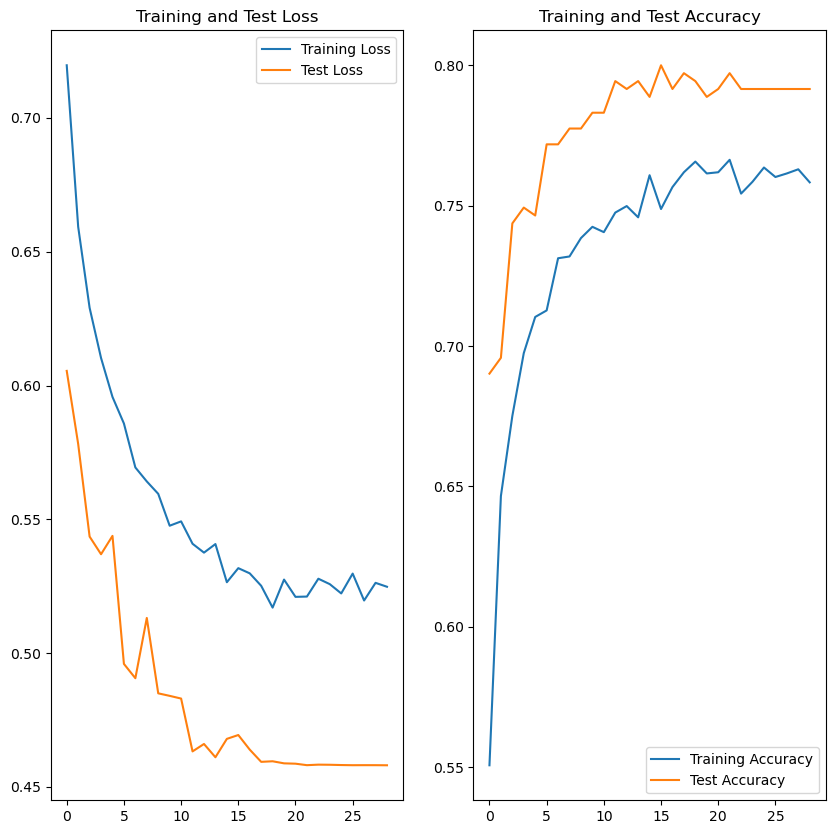

In [23]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(models_1[min(models_1)][1]+10)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.savefig('Modello_1.png')
plt.show()

### Retrain the final_model with the right n° of epochs

In [24]:
final_model_1=build_model_1(models_1[min(models_1)][0])
final_model_1.fit(X,y,epochs=20,batch_size=16,callbacks=[lr_decay_cb])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
296/296 [==============================] - 1s 2ms/step - loss: 0.7070 - accuracy: 0.5601 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.83333308492244e-05.
Epoch 2/20
296/296 [==============================] - 1s 2ms/step - loss: 0.6568 - accuracy: 0.6368 - lr: 9.8333e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.505555256813143e-05.
Epoch 3/20
296/296 [==============================] - 1s 2ms/step - loss: 0.6335 - accuracy: 0.6662 - lr: 9.5056e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.03027772437781e-05.
Epoch 4/20
296/296 [==============================] - 1s 2ms/step - loss: 0.6095 - accuracy: 0.6892 - lr: 9.0303e-05

Epoch 5: LearningRateScheduler setting learning rate to 8.428259073601415e-05.
Epoch 5/20
296/296 [==============================] - 1s 2ms/step - loss: 0.5992 - accuracy: 0.7000 - lr: 8.4283e-05

Epoch 6: Learnin

## Results

In [27]:
final_pred_1=final_model_1.predict(X_test,verbose=False)
y_test=[np.argmax(arr) for arr in y_test]
final_pred_1=[np.argmax(arr) for arr in final_pred_1]

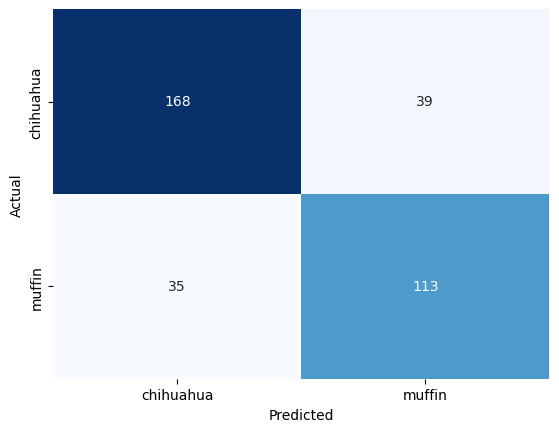

In [28]:
#Plot a confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


confusion = confusion_matrix(y_test,final_pred_1)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [29]:
print(classification_report(y_test,final_pred_1))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       207
           1       0.74      0.76      0.75       148

    accuracy                           0.79       355
   macro avg       0.79      0.79      0.79       355
weighted avg       0.79      0.79      0.79       355



In [30]:
from sklearn.metrics import zero_one_loss

final_acc_1=round(final_model_1.evaluate(test_ds,verbose=False)[1],3)
zero_one_1=round(zero_one_loss(y_test,final_pred_1),3)

print(f"The accuracy is {final_acc_1}")
print(f"The 0-1 loss is {zero_one_1}")

The accuracy is 0.792
The 0-1 loss is 0.208


# Model n°2:    CNN with (32x32) images resolution

## Set the model

In [32]:
keras.backend.clear_session()

In [33]:
def call_code_2(kernels,filters,
              neurons,neurons_1,
              activation_c,activation,
              lr,dropout
              ):
    model = keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_width,img_height,3)))
    
    #Data augmentation
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    
    # Convolutional 
    model.add(layers.Conv2D(kernel_size=kernels,filters=filters,activation=activation_c))
    model.add(layers.AveragePooling2D())
    
    if dropout :
        model.add(layers.Dropout(0.2))
        
    model.add(layers.Conv2D(kernel_size=kernels,filters=filters*2,activation=activation_c))
    
    if dropout :
        model.add(layers.Dropout(0.2))
        
    model.add(layers.Conv2D(kernel_size=kernels,filters=filters*3,activation=activation_c))
    if dropout :
        model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    
    # Dense 
    model.add(layers.Dense(units=neurons,activation=activation))
    if dropout :
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons/2,activation=activation))
    if dropout :
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons/4,activation=activation))
    if dropout :
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons_1,activation=activation))
    model.add(layers.Dense(2, activation="softmax"))
    model.compile(
        optimizer=optimizers.legacy.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

def build_model_2(hp):
    kernels=hp.Choice('kernels',[3,5])
    filters=hp.Int('filters',min_value=10,max_value=20,step=10)
    neurons=hp.Int("neurons", min_value=100, max_value=340, step=60)
    neurons_1=hp.Int("neurons_1", min_value=12, max_value=20, step=4)
    activation_c=hp.Choice('activation_c',['tanh','relu'],default='relu')
    activation=hp.Choice('activation',['tanh','relu'],default='relu')
    lr=hp.Choice('lr',[0.0005,0.0001])
    dropout=hp.Boolean('dropout',default=True)
    model = call_code_2(
        kernels=kernels,
        filters=filters,
        neurons=neurons,neurons_1=neurons_1,
        activation_c=activation_c,activation=activation,
        lr=lr,dropout=dropout

    )

    return model

## Set data 

In [31]:
# Extraction
X = []
y = []
for images, labels in tot_ds:
    X.append(images.numpy())
    y.append(labels.numpy())
X = np.concatenate(X)
y = np.concatenate(y)

In [32]:
# Extraction
X_test = []
y_test = []
for images, labels in test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

## Statistical risk estimation

In [36]:
# For insights, look at the first model estimation

from sklearn.model_selection import train_test_split,KFold

models_2={}

Folds_outer = KFold(n_splits=5, shuffle=True)

folds_counter=0
for tr_idx_out, te_idx_out in Folds_outer.split(X):
    x_train_out, x_test_out = X[tr_idx_out], X[te_idx_out]
    y_train_out, y_test_out = y[tr_idx_out], y[te_idx_out]

    x_train_in, x_val_in, y_train_in, y_val_in = train_test_split(x_train_out, y_train_out, test_size=0.2, random_state=123)
     
    trials=40
    
    tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_2,
    objective="val_accuracy",
    max_trials=trials,
    executions_per_trial=1,
    overwrite=True,
    directory="Tuning",
    project_name="ChvsMf")
    
    #Set the callbacks
    lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
    
    #Create a dictionary to store the epochs and the val_loss of the trials
    tuner_metrics={} 
    for i in range(0,trials-1):
        tuner_metrics[i] = None 
    
    tuner.search(x_train_in,y_train_in,epochs=25,batch_size=16,
                 validation_data=(x_val_in,y_val_in),
                 callbacks=[stop_early,lr_decay_cb],
                 verbose=True)
    
    for c,trial in enumerate(tuner.oracle.trials.values()):

        val_value = trial.metrics.get_history('val_loss')
        for obs in val_value:
            value=obs.value[0]
            step=obs.step
        tuner_metrics[c]={'value':value,'epochs':step}

    best_trial = min(tuner_metrics.values(), key=lambda x: x['value'])
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    outer_ep= best_trial['epochs']
    
    #Refit the model
    outer_model=build_model_2(best_hps)
    outer_model.fit(x_train_out,y_train_out,epochs=outer_ep,batch_size=16,
                    callbacks=[lr_decay_cb])   

    y_pred_out = outer_model.predict(x_test_out)

    stat_risk=CV_zerone_loss(y_test_out,y_pred_out)
    models_2[stat_risk]=(best_hps,outer_ep)
    
    folds_counter+=1
    
    print('')
    print(f" FOLDS {folds_counter} COMPLETE")
    print('')

est_risk_2=np.mean(list(models_2.keys()))

print(f"The estimated 0-1 risk for these models is {est_risk_2}")





Trial 40 Complete [00h 00m 21s]
val_accuracy: 0.8456464409828186

Best val_accuracy So Far: 0.870712399482727
Total elapsed time: 06h 22m 34s

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/12
237/237 [==============================] - 2s 7ms/step - loss: 0.6390 - accuracy: 0.6295 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004916666900195802.
Epoch 2/12
237/237 [==============================] - 2s 7ms/step - loss: 0.5116 - accuracy: 0.7589 - lr: 4.9167e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00047527777690750856.
Epoch 3/12
237/237 [==============================] - 2s 7ms/step - loss: 0.4461 - accuracy: 0.8009 - lr: 4.7528e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045151388621889055.
Epoch 4/12
237/237 [==============================] - 2s 7ms/step - loss: 0.4078 - accuracy: 0.8276 - lr: 4.5151e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000421412

## Final model evaluation

In [40]:
models_2[min(models_2)][0].values

{'kernels': 3,
 'filters': 20,
 'neurons': 340,
 'neurons_1': 16,
 'activation_c': 'relu',
 'activation': 'relu',
 'lr': 0.0005,
 'dropout': False}

In [41]:
final_model_2=build_model_2(models_2[min(models_2)][0])

In [42]:
history=final_model_2.fit(X,y,epochs=models_2[min(models_2)][1]+10,batch_size=16,
                  validation_data=(X_test,y_test),
                  callbacks=[lr_decay_cb])


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/23
296/296 [==============================] - 3s 9ms/step - loss: 0.5986 - accuracy: 0.6753 - val_loss: 0.4817 - val_accuracy: 0.8056 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004916666900195802.
Epoch 2/23
296/296 [==============================] - 3s 8ms/step - loss: 0.4923 - accuracy: 0.7676 - val_loss: 0.3937 - val_accuracy: 0.8394 - lr: 4.9167e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00047527777690750856.
Epoch 3/23
296/296 [==============================] - 3s 9ms/step - loss: 0.4386 - accuracy: 0.7991 - val_loss: 0.3749 - val_accuracy: 0.8310 - lr: 4.7528e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045151388621889055.
Epoch 4/23
296/296 [==============================] - 3s 9ms/step - loss: 0.3894 - accuracy: 0.8293 - val_loss: 0.3555 - val_accuracy: 0.8451 - lr: 4.5151e-04

Epoch 5: LearningRateScheduler setting le

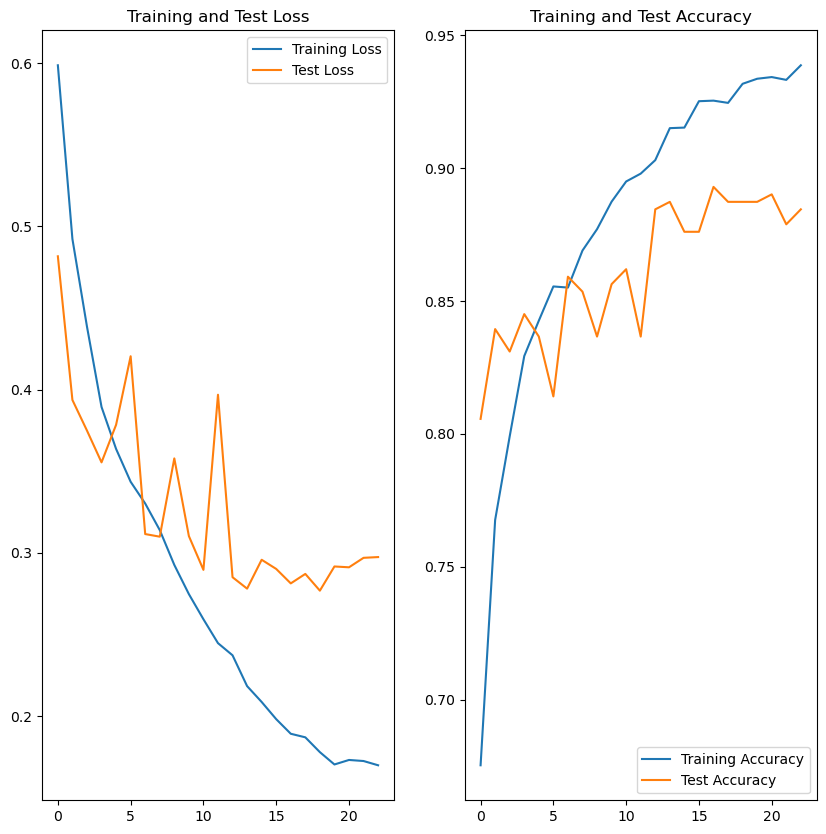

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(models_2[min(models_2)][1]+10)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.savefig('Modello_2.png')
plt.show()

## Retrain the final_model with the right n° of epochs

In [44]:
final_model_2=build_model_2(models_2[min(models_2)][0])
final_model_2.fit(X,y,epochs=models_2[min(models_2)][1],batch_size=16,
                  validation_data=(X_test,y_test),
                  callbacks=[lr_decay_cb])


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/13
296/296 [==============================] - 3s 9ms/step - loss: 0.5582 - accuracy: 0.7091 - val_loss: 0.5769 - val_accuracy: 0.6732 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004916666900195802.
Epoch 2/13
296/296 [==============================] - 3s 9ms/step - loss: 0.4410 - accuracy: 0.7999 - val_loss: 0.4563 - val_accuracy: 0.7775 - lr: 4.9167e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00047527777690750856.
Epoch 3/13
296/296 [==============================] - 3s 9ms/step - loss: 0.3973 - accuracy: 0.8223 - val_loss: 0.3644 - val_accuracy: 0.8225 - lr: 4.7528e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045151388621889055.
Epoch 4/13
296/296 [==============================] - 3s 9ms/step - loss: 0.3875 - accuracy: 0.8295 - val_loss: 0.3901 - val_accuracy: 0.8225 - lr: 4.5151e-04

Epoch 5: LearningRateScheduler setting le

## Results

In [35]:
final_pred_2=final_model_2.predict(X_test,verbose=False)
y_test=[np.argmax(arr) for arr in y_test]
final_pred_2=[np.argmax(arr) for arr in final_pred_2]

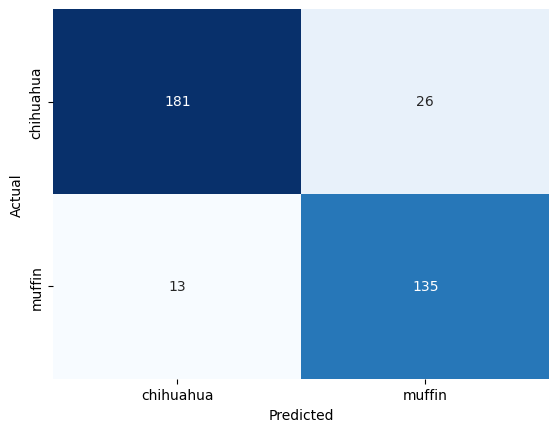

In [36]:
#Plot a confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


confusion = confusion_matrix(y_test,final_pred_2)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [37]:
print(classification_report(y_test,final_pred_2))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       207
           1       0.84      0.91      0.87       148

    accuracy                           0.89       355
   macro avg       0.89      0.89      0.89       355
weighted avg       0.89      0.89      0.89       355



In [38]:
from sklearn.metrics import zero_one_loss

final_acc_2=round(final_model_2.evaluate(test_ds,verbose=False)[1],3)
zero_one_2=round(zero_one_loss(y_test,final_pred_2),3)

print(f"The accuracy is {final_acc_2}")
print(f"The 0-1 loss is {zero_one_2}")

The accuracy is 0.89
The 0-1 loss is 0.11


# Model n°3: CNN with resolution of (64x64)

## Set the model 

In [52]:
keras.backend.clear_session()

In [39]:
img_width=64
img_height=64

In [10]:
def call_code_3(kernels,filters,
              neurons,neurons_1,
              activation_c,activation,
              lr,dropout
              ):
    model = keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_width,img_height,3)))
    
    #Data augmentation
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    
    # Convolutional 
    model.add(layers.Conv2D(kernel_size=kernels,filters=filters,activation=activation_c))
    model.add(layers.AveragePooling2D())
    
    if dropout :
        model.add(layers.Dropout(0.2))
        
    model.add(layers.Conv2D(kernel_size=kernels,filters=filters*2,activation=activation_c))
    
    if dropout :
        model.add(layers.Dropout(0.2))
        
    model.add(layers.Conv2D(kernel_size=kernels,filters=filters*3,activation=activation_c))
    if dropout :
        model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    
    # Dense 
    model.add(layers.Dense(units=neurons,activation=activation))
    if dropout :
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons/2,activation=activation))
    if dropout :
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons/4,activation=activation))
    if dropout :
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=neurons_1,activation=activation))
    model.add(layers.Dense(2, activation="softmax"))
    model.compile(
        optimizer=optimizers.legacy.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

def build_model_3(hp):
    kernels=hp.Choice('kernels',[3,5])
    filters=hp.Int('filters',min_value=10,max_value=20,step=10)
    neurons=hp.Int("neurons", min_value=100, max_value=340, step=60)
    neurons_1=hp.Int("neurons_1", min_value=12, max_value=20, step=4)
    activation_c=hp.Choice('activation_c',['tanh','relu'],default='relu')
    activation=hp.Choice('activation',['tanh','relu'],default='relu')
    lr=hp.Choice('lr',[0.0005,0.0001])
    dropout=hp.Boolean('dropout',default=True)
    model = call_code_3(
        kernels=kernels,
        filters=filters,
        neurons=neurons,neurons_1=neurons_1,
        activation_c=activation_c,activation=activation,
        lr=lr,dropout=dropout

    )

    return model


## Set data 

In [40]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 4733 files belonging to 2 classes.


In [41]:
add_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='training',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 1184 files belonging to 2 classes.
Using 829 files for training.


In [42]:
test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='validation',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 1184 files belonging to 2 classes.
Using 355 files for validation.


In [43]:
tot_ds=train_ds.concatenate(add_ds)
len(tot_ds)

5562

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
tot_ds = train_ds.cache().shuffle(buffer_size=4000).prefetch(buffer_size=AUTOTUNE)

In [45]:
# Extraction
X = []
y = []
for images, labels in tot_ds:
    X.append(images.numpy())
    y.append(labels.numpy())
X = np.concatenate(X)
y = np.concatenate(y)

In [46]:
# Extraction
X_test = []
y_test = []
for images, labels in test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

## Statistical risk estimation

In [21]:
# For insights, look at the first model estimation

from sklearn.model_selection import train_test_split,KFold

models_3={}

# Divide into folds
Folds_outer = KFold(n_splits=5, shuffle=True)

folds_counter=0
for tr_idx_out, te_idx_out in Folds_outer.split(X):
    x_train_out, x_test_out = X[tr_idx_out], X[te_idx_out]
    y_train_out, y_test_out = y[tr_idx_out], y[te_idx_out]

    x_train_in, x_val_in, y_train_in, y_val_in = train_test_split(x_train_out, y_train_out, test_size=0.2, random_state=123)
     
    #Set the tuner
    trials=40
    
    tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_3,
    objective="val_accuracy",
    max_trials=trials,
    executions_per_trial=1,
    overwrite=True,
    directory="Tuning",
    project_name="ChvsMf")
    
    #Get the callbacks
    lr_decay_cb = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
    
    #Create a dictionary to store the epochs and the val_loss of the trials
    tuner_metrics={} 
    for i in range(0,trials-1):
        tuner_metrics[i] = None 
    
    tuner.search(x_train_in,y_train_in,epochs=25,batch_size=16,
                 validation_data=(x_val_in,y_val_in),
                 callbacks=[stop_early,lr_decay_cb],
                 verbose=True)
    
    for c,trial in enumerate(tuner.oracle.trials.values()):

        val_value = trial.metrics.get_history('val_loss')
        for obs in val_value:
            value=obs.value[0]
            step=obs.step
        tuner_metrics[c]={'value':value,'epochs':step}

    best_trial = min(tuner_metrics.values(), key=lambda x: x['value'])
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    outer_ep= best_trial['epochs']
    
    #Refit the model
    outer_model=build_model_3(best_hps)
    outer_model.fit(x_train_out,y_train_out,epochs=outer_ep,batch_size=16,
                    callbacks=[lr_decay_cb])   

    y_pred_out = outer_model.predict(x_test_out)

    stat_risk=CV_zerone_loss(y_test_out,y_pred_out)
    models_3[stat_risk]=(best_hps,outer_ep)
    
    folds_counter+=1
    
    print('')
    print(f" FOLDS {folds_counter} COMPLETE")
    print('')

est_risk_3=np.mean(list(models_3.keys()))

print(f"The estimated 0-1 risk for these models is {est_risk_3}")

Trial 40 Complete [00h 03m 26s]
val_accuracy: 0.9010553956031799

Best val_accuracy So Far: 0.9076517224311829
Total elapsed time: 01h 25m 23s

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/18
237/237 [==============================] - 10s 41ms/step - loss: 0.7010 - accuracy: 0.5397 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004916666900195802.
Epoch 2/18
237/237 [==============================] - 10s 41ms/step - loss: 0.6027 - accuracy: 0.6829 - lr: 4.9167e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00047527777690750856.
Epoch 3/18
237/237 [==============================] - 10s 42ms/step - loss: 0.5256 - accuracy: 0.7613 - lr: 4.7528e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00045151388621889055.
Epoch 4/18
237/237 [==============================] - 10s 42ms/step - loss: 0.4422 - accuracy: 0.8104 - lr: 4.5151e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.

## Final model evaluation

In [25]:
models_3[min(models_3)][0].values 

{'kernels': 5,
 'filters': 20,
 'neurons': 220,
 'neurons_1': 12,
 'activation_c': 'relu',
 'activation': 'tanh',
 'lr': 0.0001,
 'dropout': False}

In [26]:
final_model_3=build_model_3(models_3[min(models_3)][0])
history=final_model_3.fit(X,y,epochs=models_3[min(models_3)][1]+10,
                          validation_data=(X_test,y_test),
                          batch_size=16,callbacks=[lr_decay_cb])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/24
296/296 [==============================] - 12s 41ms/step - loss: 0.5592 - accuracy: 0.7152 - val_loss: 0.4462 - val_accuracy: 0.7944 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.83333308492244e-05.
Epoch 2/24
296/296 [==============================] - 12s 40ms/step - loss: 0.4557 - accuracy: 0.7965 - val_loss: 0.3798 - val_accuracy: 0.8451 - lr: 9.8333e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.505555256813143e-05.
Epoch 3/24
296/296 [==============================] - 12s 41ms/step - loss: 0.4064 - accuracy: 0.8267 - val_loss: 0.3506 - val_accuracy: 0.8535 - lr: 9.5056e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.03027772437781e-05.
Epoch 4/24
296/296 [==============================] - 11s 38ms/step - loss: 0.3761 - accuracy: 0.8394 - val_loss: 0.3380 - val_accuracy: 0.8563 - lr: 9.0303e-05

Epoch 5: LearningRateScheduler settin

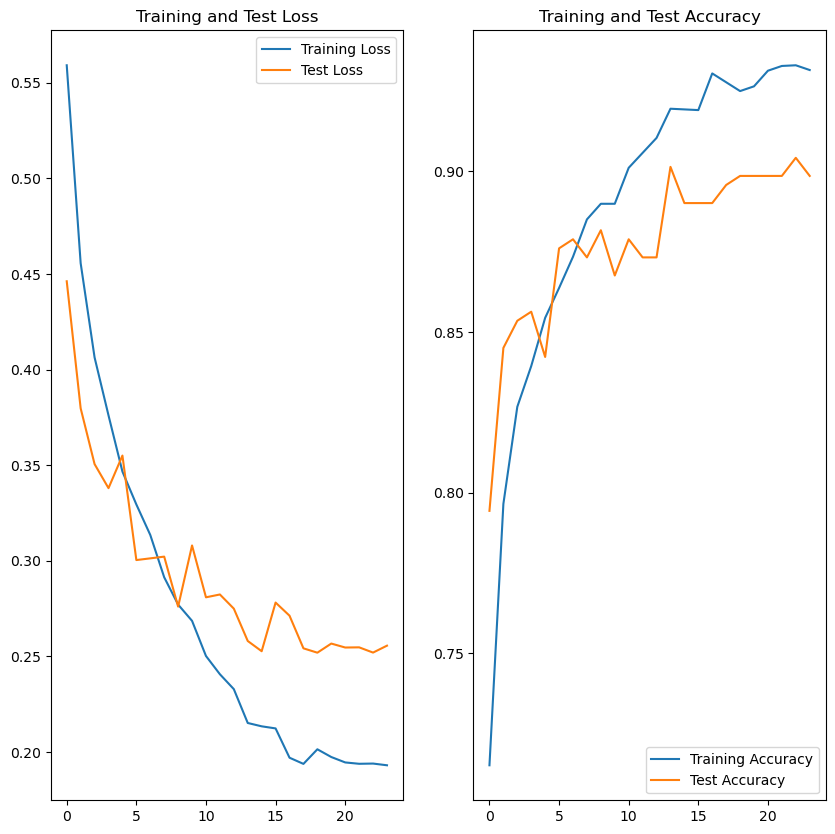

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(models_3[min(models_3)][1]+10)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.savefig('Modello_3.png')
plt.show()

## Retrain the final_model with the right n° of epochs

In [38]:
final_model_3=build_model_3(models_3[min(models_3)][0])
final_model_3.fit(X,y,epochs=20,batch_size=16,callbacks=[lr_decay_cb])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
296/296 [==============================] - 14s 46ms/step - loss: 0.5339 - accuracy: 0.7325 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.83333308492244e-05.
Epoch 2/20
296/296 [==============================] - 13s 44ms/step - loss: 0.4347 - accuracy: 0.8048 - lr: 9.8333e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.505555256813143e-05.
Epoch 3/20
296/296 [==============================] - 11s 38ms/step - loss: 0.4067 - accuracy: 0.8210 - lr: 9.5056e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.03027772437781e-05.
Epoch 4/20
296/296 [==============================] - 11s 38ms/step - loss: 0.3601 - accuracy: 0.8515 - lr: 9.0303e-05

Epoch 5: LearningRateScheduler setting learning rate to 8.428259073601415e-05.
Epoch 5/20
296/296 [==============================] - 11s 38ms/step - loss: 0.3454 - accuracy: 0.8515 - lr: 8.4283e-05

Epoch 

## Resuts

In [49]:
final_pred_3=final_model_3.predict(X_test,verbose=False)
y_test=[np.argmax(arr) for arr in y_test]
final_pred_3=[np.argmax(arr) for arr in final_pred_3]

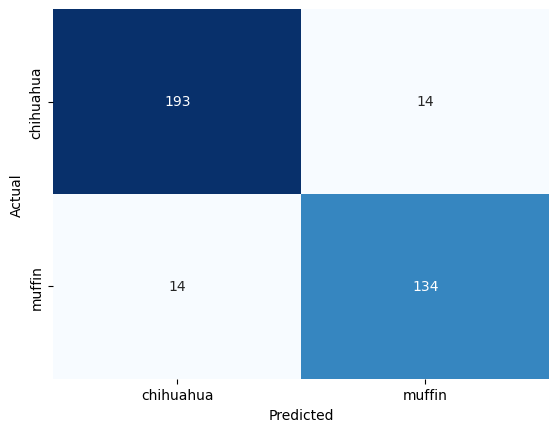

In [50]:
#Plot a confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


confusion = confusion_matrix(y_test,final_pred_3)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [51]:
print(classification_report(y_test,final_pred_3))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       207
           1       0.91      0.91      0.91       148

    accuracy                           0.92       355
   macro avg       0.92      0.92      0.92       355
weighted avg       0.92      0.92      0.92       355



In [52]:
from sklearn.metrics import zero_one_loss

final_acc_3=round(final_model_3.evaluate(test_ds,verbose=False)[1],3)
zero_one_3=round(zero_one_loss(y_test,final_pred_3),3)

print(f"The accuracy is {final_acc_3}")
print(f"The 0-1 loss is {zero_one_3}")

The accuracy is 0.921
The 0-1 loss is 0.079


# Model n°4:  VGG pre-trained model

## Set the model 

In [69]:
keras.backend.clear_session()

In [70]:
from keras.applications import VGG16
from keras.models import Model

pre_train = VGG16(weights='imagenet',input_shape=(224, 224, 3))

for layer in pre_train.layers:
    layer.trainable = False


In [71]:
#Add layers

x = pre_train.output
x = layers.Dropout(0.1)(x)
x = layers.Dense(500, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(250, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(120, activation='relu')(x)
x = layers.Dense(60, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)

#Set the model
model_4 = Model(inputs=pre_train.input, outputs=predictions)

model_4.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])


## Set data

In [72]:
img_width=224
img_height=224

In [73]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 4733 files belonging to 2 classes.


In [74]:
add_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='training',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 1184 files belonging to 2 classes.
Using 829 files for training.


In [75]:
test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='validation',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(img_width,img_height)
)

Found 1184 files belonging to 2 classes.
Using 355 files for validation.


In [76]:
tot_ds=train_ds.concatenate(add_ds)
len(tot_ds)

5562

In [77]:
AUTOTUNE = tf.data.AUTOTUNE
tot_ds = train_ds.cache().shuffle(buffer_size=4000).prefetch(buffer_size=AUTOTUNE)

In [78]:
# Extraction
X = []
y = []
for images, labels in tot_ds:
    X.append(images.numpy())
    y.append(labels.numpy())
X = np.concatenate(X)
y = np.concatenate(y)

In [79]:
# Extraction
X_test = []
y_test = []
for images, labels in test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

## Fine-tuning the model

In [80]:
model_4.fit(X,y,epochs=4,batch_size=16,
          validation_data=(X_test,y_test),
          callbacks=[lr_decay_cb])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/4
296/296 [==============================] - 554s 2s/step - loss: 0.4363 - accuracy: 0.8316 - val_loss: 0.1636 - val_accuracy: 0.9437 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.83333308492244e-05.
Epoch 2/4
296/296 [==============================] - 578s 2s/step - loss: 0.1294 - accuracy: 0.9484 - val_loss: 0.1224 - val_accuracy: 0.9662 - lr: 9.8333e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.505555256813143e-05.
Epoch 3/4
296/296 [==============================] - 583s 2s/step - loss: 0.1063 - accuracy: 0.9592 - val_loss: 0.1138 - val_accuracy: 0.9634 - lr: 9.5056e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.03027772437781e-05.
Epoch 4/4
296/296 [==============================] - 585s 2s/step - loss: 0.0910 - accuracy: 0.9670 - val_loss: 0.1176 - val_accuracy: 0.9606 - lr: 9.0303e-05


## Results

In [83]:
final_pred_4=model_4.predict(X_test,verbose=True)
y_test=[np.argmax(arr) for arr in y_test]
final_pred_4=[np.argmax(arr) for arr in final_pred_4]

12/12 [==============================] - 40s 3s/step


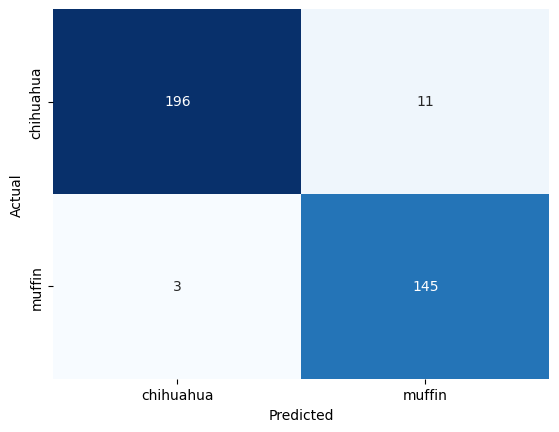

In [84]:
#Plot a confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


confusion = confusion_matrix(y_test,final_pred_4)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [85]:
print(classification_report(y_test,final_pred_4))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       207
           1       0.93      0.98      0.95       148

    accuracy                           0.96       355
   macro avg       0.96      0.96      0.96       355
weighted avg       0.96      0.96      0.96       355



In [86]:
f_one_4 =round(classification_report(y_test,final_pred_4,output_dict=True)['weighted avg']['f1-score'],3)

In [87]:
from sklearn.metrics import zero_one_loss

final_acc_4=round(model_4.evaluate(test_ds,verbose=False)[1],3)
zero_one_4=round(zero_one_loss(y_test,final_pred_4),3)

print(f"The accuracy is {final_acc_4}")
print(f"The 0-1 loss is {zero_one_4}")

The accuracy is 0.961
The 0-1 loss is 0.039


# Models comparison

The table below summurize the results for the four classifier trained in the project. 
The first two lines report the performance of the final models while the last one is about the estimation of the expected minal risk for the three architectures created from scratch.

In [88]:
table=[['','NN','CNN_32','CNN_64','VGG'],
       
       ['0-1 loss',zero_one_1,zero_one_2,zero_one_3,zero_one_4],
       ['accuracy',final_acc_1,final_acc_2,final_acc_3,final_acc_4],
       ['stat_risk',round(float(est_risk),3),round(float(est_risk_2),3),round(float(est_risk_3),3),'-'],
      ]
print(tabulate(table,tablefmt='fancy_grid',stralign='center'))

╒═══════════╤═══════╤════════╤════════╤═══════╕
│           │  NN   │ CNN_32 │ CNN_64 │  VGG  │
├───────────┼───────┼────────┼────────┼───────┤
│ 0-1 loss  │ 0.208 │  0.11  │ 0.079  │ 0.039 │
├───────────┼───────┼────────┼────────┼───────┤
│ accuracy  │ 0.792 │  0.89  │ 0.921  │ 0.961 │
├───────────┼───────┼────────┼────────┼───────┤
│ stat_risk │ 0.233 │ 0.141  │ 0.113  │   -   │
╘═══════════╧═══════╧════════╧════════╧═══════╛


## Misclassified images from CNN_64

In [89]:
test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='validation',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(64,64)
)

Found 1184 files belonging to 2 classes.
Using 355 files for validation.


In [90]:
# Extraction
X_test = []
y_test = []
for images, labels in test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [91]:
#Make again the predictions

final_pred_3=final_model_3.predict(X_test,verbose=False)
y_test=np.array([np.argmax(arr) for arr in y_test])
final_pred_3=np.array([np.argmax(arr) for arr in final_pred_3])

In [92]:
# Store the misclassified indices
misc_ind = np.where(final_pred_3 != y_test)[0]
print(misc_ind)

[  8  19  26  46  49  66  68  82  89 103 117 142 149 164 166 181 187 188
 212 224 238 266 277 286 318 323 341 343]


In [93]:
# Get a better image quality for the plot

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    subset='validation',
    validation_split=0.3,
    seed=123,
    shuffle=True,
    image_size=(258,258)
)

Found 1184 files belonging to 2 classes.
Using 355 files for validation.


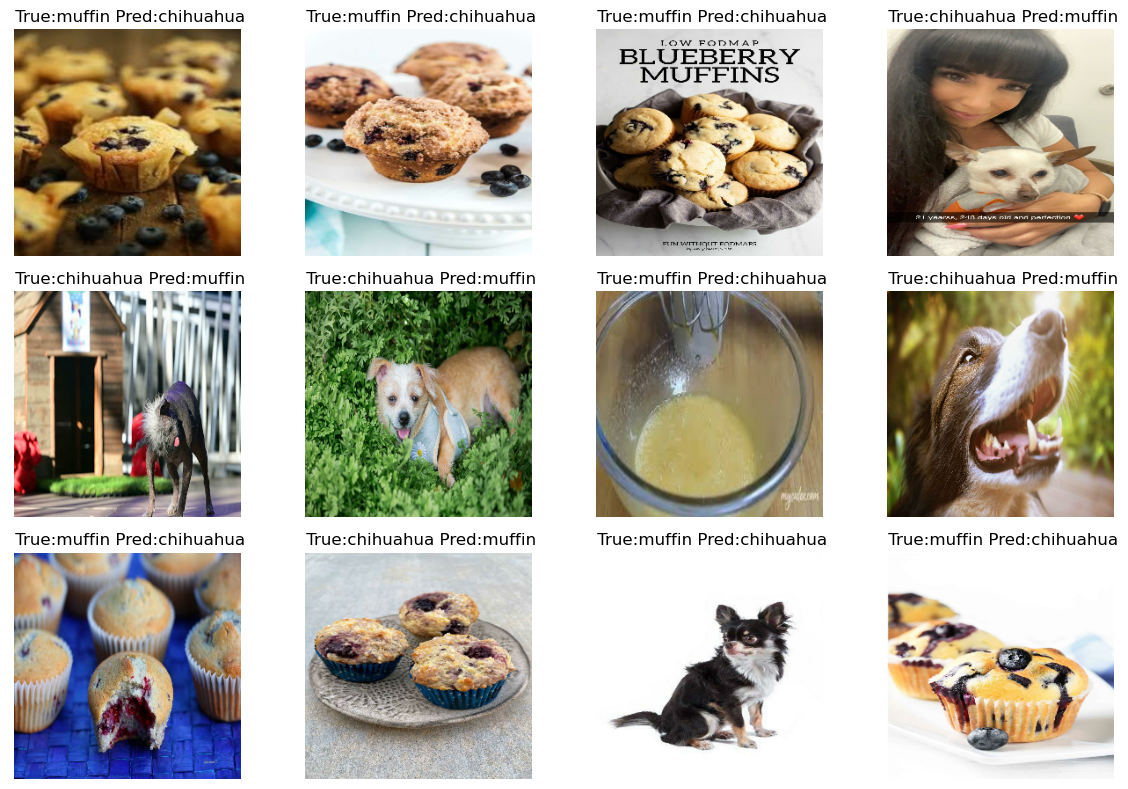

In [94]:
#Plot twelve images that have been misclassified by the model


misc_rnd = np.random.choice(misc_ind, size=12, replace=False)  # Get ten images
# Set the subplot
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

# Set a counter for the images
index_counter = 0

for (images,_) in test_ds:
    for image in images:
        if index_counter < len(misc_rnd):
            idx = misc_ind[index_counter]
            row = index_counter // 4
            col = index_counter % 4

            #Define the position of the images
            axs[row, col].imshow(image.numpy().astype("uint8"))
            axs[row, col].set_title(f" True:{class_names[y_test[idx]]} Pred:{class_names[final_pred_3[idx]]}")
            axs[row, col].axis('off')

            index_counter += 1
        else:
            break

    #Break once we plot the last image in the misclassified list
    if index_counter >= len(misc_ind):
        break

# Adjust and plot
plt.tight_layout()
plt.show()